# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

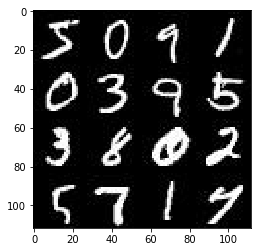

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

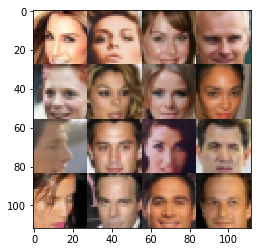

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
    'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels])
    tensor_Z = tf.placeholder(tf.float32,[None,z_dim])
    learn_rate = tf.placeholder(tf.float32)
    return input_image, tensor_Z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [58]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.19
    batchSize,height_i,width_i,deepth_i = images.get_shape().as_list()
    kernal_size = 5
    stridesNum = 2
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input layer is height_i x width_i x deepth_i
        Layer1 = tf.layers.conv2d(images, 64, kernal_size, strides=stridesNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * Layer1, Layer1)
        relu1 = tf.nn.dropout(relu1,0.8)
        # Now height_i-kernal_size x width_i/2 x 64
        #print(relu1.shape)
        
        Layer2 = tf.layers.conv2d(relu1, 128, kernal_size, strides=stridesNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(Layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,0.8)
        # height_i/4 x width_i/4 x 128
        #print(relu2.shape)
        
        Layer3 = tf.layers.conv2d(relu2, 256, kernal_size, strides=stridesNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(Layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,0.8)
        # height_i/8 x width_i/8 x 256
        #print(relu3.shape)
        
        Layer4 = tf.layers.conv2d(relu3, 512, kernal_size, strides=stridesNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(Layer4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.nn.dropout(relu4,0.8)
        # height_i/8 x width_i/8 x 256
        #print(relu4.shape)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        #print(logits.shape)
        outputs = tf.sigmoid(logits)
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [59]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        kernal_size = 5
        strideNum = 2
        alpha=0.2
        # First fully connected layer
        gLayer1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        gLayer1 = tf.reshape(gLayer1, (-1,4,4, 512))
        gLayer1 = tf.layers.batch_normalization(gLayer1, training=is_train)
        relu1 = tf.maximum(alpha * gLayer1, gLayer1)
        # 5x5x256 now
        #print(relu1.shape)        
        gLayer2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid',\
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        gLayer2 = tf.layers.batch_normalization(gLayer2, training=is_train)
        relu2 = tf.maximum(alpha * gLayer2, gLayer2)
        relu2 = tf.nn.dropout(relu2,0.8)
        #print(relu2.shape)
        gLayer3 = tf.layers.conv2d_transpose(relu2, 128, kernal_size, strides=strideNum, padding='same',\
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        gLayer3 = tf.layers.batch_normalization(gLayer3, training=is_train)
        relu3 = tf.maximum(alpha * gLayer3, gLayer3)
        relu3 = tf.nn.dropout(relu3,0.8)
        # 14x14x128 now
        #print(relu3.shape)        
        gLayer4 = tf.layers.conv2d_transpose(relu3, 64, kernal_size, strides=strideNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        gLayer4 = tf.layers.batch_normalization(gLayer4, training=is_train)
        relu4 = tf.maximum(alpha * gLayer4, gLayer4)
        relu4 = tf.nn.dropout(relu4,0.8)
        # 14x14x128 now
        #print(relu4.shape)        
        # Output layer
        g_logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, kernal_size, strides=1, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28 x out_channel_dim now
        #print(g_logits.shape)        
        g_outputs = tf.tanh(g_logits)
    return g_outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [60]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [61]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [63]:
import math
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step_count = 0
    
    input_real, input_z,l_rate = model_inputs(data_shape[2],data_shape[1],data_shape[3], z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt,g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    print_info_batch_cnt = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        lastBatchesTime = time.time()
        for epoch_i in range(epoch_count):
            batch_cnt = 0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                step_count += 1
                batch_cnt += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # TODO: Train Model
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,l_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,l_rate:learning_rate })
                # Run g_optim twice to make sure that d_loss does not go to zero
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,l_rate:learning_rate })
                
                if step_count % print_info_batch_cnt == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(batch_cnt,math.ceil(data_shape[0]/batch_images.shape[0])),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    print("This {} batches takes:{:.4f} sec".format(print_info_batch_cnt,(time.time()-lastBatchesTime)))
                    lastBatchesTime = time.time()
                    
                if step_count % 200 == 0:
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)
        show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 20/938... Discriminator Loss: 2.6520... Generator Loss: 0.2155
This 20 batches takes:35.3602 sec
Epoch 1/2... Batch 40/938... Discriminator Loss: 1.3746... Generator Loss: 0.6024
This 20 batches takes:34.3414 sec
Epoch 1/2... Batch 60/938... Discriminator Loss: 1.2649... Generator Loss: 1.5260
This 20 batches takes:34.3244 sec
Epoch 1/2... Batch 80/938... Discriminator Loss: 1.4786... Generator Loss: 0.9079
This 20 batches takes:34.3304 sec
Epoch 1/2... Batch 100/938... Discriminator Loss: 1.8132... Generator Loss: 0.7207
This 20 batches takes:34.3004 sec
Epoch 1/2... Batch 120/938... Discriminator Loss: 1.3689... Generator Loss: 0.9686
This 20 batches takes:34.3214 sec
Epoch 1/2... Batch 140/938... Discriminator Loss: 1.5053... Generator Loss: 0.7755
This 20 batches takes:34.3144 sec
Epoch 1/2... Batch 160/938... Discriminator Loss: 2.3338... Generator Loss: 0.7590
This 20 batches takes:35.2621 sec
Epoch 1/2... Batch 180/938... Discriminator Loss: 1.4866... Generato

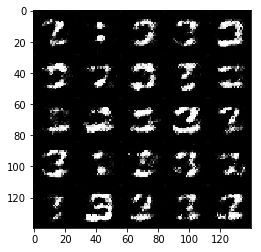

Epoch 1/2... Batch 220/938... Discriminator Loss: 1.7101... Generator Loss: 0.7712
This 20 batches takes:35.4138 sec
Epoch 1/2... Batch 240/938... Discriminator Loss: 1.6222... Generator Loss: 0.6026
This 20 batches takes:34.4095 sec
Epoch 1/2... Batch 260/938... Discriminator Loss: 1.4772... Generator Loss: 0.8825
This 20 batches takes:34.4474 sec
Epoch 1/2... Batch 280/938... Discriminator Loss: 1.5204... Generator Loss: 0.8153
This 20 batches takes:34.5429 sec
Epoch 1/2... Batch 300/938... Discriminator Loss: 1.5508... Generator Loss: 0.7714
This 20 batches takes:34.4994 sec
Epoch 1/2... Batch 320/938... Discriminator Loss: 1.4370... Generator Loss: 0.7380
This 20 batches takes:34.4315 sec
Epoch 1/2... Batch 340/938... Discriminator Loss: 1.4369... Generator Loss: 0.8866
This 20 batches takes:34.5005 sec
Epoch 1/2... Batch 360/938... Discriminator Loss: 1.5457... Generator Loss: 0.6549
This 20 batches takes:34.5784 sec
Epoch 1/2... Batch 380/938... Discriminator Loss: 1.3404... Gene

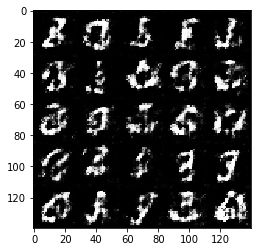

Epoch 1/2... Batch 420/938... Discriminator Loss: 1.6277... Generator Loss: 0.6349
This 20 batches takes:35.2981 sec
Epoch 1/2... Batch 440/938... Discriminator Loss: 1.4183... Generator Loss: 0.8105
This 20 batches takes:34.3257 sec
Epoch 1/2... Batch 460/938... Discriminator Loss: 1.6259... Generator Loss: 1.2275
This 20 batches takes:34.4128 sec
Epoch 1/2... Batch 480/938... Discriminator Loss: 1.3413... Generator Loss: 1.0080
This 20 batches takes:34.4427 sec
Epoch 1/2... Batch 500/938... Discriminator Loss: 1.6900... Generator Loss: 0.4523
This 20 batches takes:34.4732 sec
Epoch 1/2... Batch 520/938... Discriminator Loss: 1.4135... Generator Loss: 0.8322
This 20 batches takes:34.4271 sec
Epoch 1/2... Batch 540/938... Discriminator Loss: 1.3287... Generator Loss: 1.2422
This 20 batches takes:34.4873 sec
Epoch 1/2... Batch 560/938... Discriminator Loss: 1.6919... Generator Loss: 0.3844
This 20 batches takes:34.3334 sec
Epoch 1/2... Batch 580/938... Discriminator Loss: 1.3153... Gene

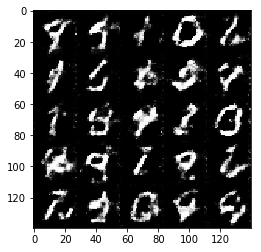

Epoch 1/2... Batch 620/938... Discriminator Loss: 1.2486... Generator Loss: 1.2001
This 20 batches takes:35.2311 sec
Epoch 1/2... Batch 640/938... Discriminator Loss: 1.2654... Generator Loss: 0.9220
This 20 batches takes:34.2814 sec
Epoch 1/2... Batch 660/938... Discriminator Loss: 1.6548... Generator Loss: 0.6841
This 20 batches takes:34.3154 sec
Epoch 1/2... Batch 680/938... Discriminator Loss: 1.5115... Generator Loss: 0.6683
This 20 batches takes:34.2774 sec
Epoch 1/2... Batch 700/938... Discriminator Loss: 1.6509... Generator Loss: 0.6308
This 20 batches takes:34.2834 sec
Epoch 1/2... Batch 720/938... Discriminator Loss: 1.6878... Generator Loss: 0.7883
This 20 batches takes:34.3184 sec
Epoch 1/2... Batch 740/938... Discriminator Loss: 1.5207... Generator Loss: 0.5307
This 20 batches takes:34.3094 sec
Epoch 1/2... Batch 760/938... Discriminator Loss: 1.4237... Generator Loss: 0.8888
This 20 batches takes:34.3274 sec
Epoch 1/2... Batch 780/938... Discriminator Loss: 1.4072... Gene

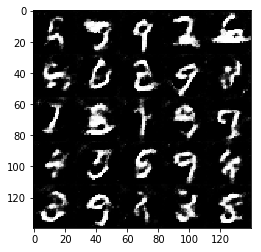

Epoch 1/2... Batch 820/938... Discriminator Loss: 1.4247... Generator Loss: 0.6995
This 20 batches takes:35.1971 sec
Epoch 1/2... Batch 840/938... Discriminator Loss: 1.2628... Generator Loss: 0.9174
This 20 batches takes:34.2838 sec
Epoch 1/2... Batch 860/938... Discriminator Loss: 1.3700... Generator Loss: 0.9291
This 20 batches takes:34.3183 sec
Epoch 1/2... Batch 880/938... Discriminator Loss: 1.3329... Generator Loss: 1.0692
This 20 batches takes:34.3184 sec
Epoch 1/2... Batch 900/938... Discriminator Loss: 1.1691... Generator Loss: 0.7559
This 20 batches takes:34.2764 sec
Epoch 1/2... Batch 920/938... Discriminator Loss: 1.4146... Generator Loss: 0.9111
This 20 batches takes:34.2994 sec
Epoch 2/2... Batch 3/938... Discriminator Loss: 1.3398... Generator Loss: 1.0296
This 20 batches takes:34.2904 sec
Epoch 2/2... Batch 23/938... Discriminator Loss: 1.0984... Generator Loss: 1.0909
This 20 batches takes:34.2714 sec
Epoch 2/2... Batch 43/938... Discriminator Loss: 1.5189... Generato

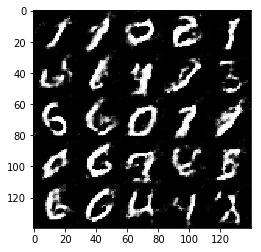

Epoch 2/2... Batch 83/938... Discriminator Loss: 1.3659... Generator Loss: 0.6516
This 20 batches takes:35.1500 sec
Epoch 2/2... Batch 103/938... Discriminator Loss: 1.4054... Generator Loss: 1.1180
This 20 batches takes:34.2454 sec
Epoch 2/2... Batch 123/938... Discriminator Loss: 1.3128... Generator Loss: 0.9613
This 20 batches takes:34.2144 sec
Epoch 2/2... Batch 143/938... Discriminator Loss: 1.2261... Generator Loss: 0.9360
This 20 batches takes:34.2514 sec
Epoch 2/2... Batch 163/938... Discriminator Loss: 1.5188... Generator Loss: 0.9539
This 20 batches takes:34.2574 sec
Epoch 2/2... Batch 183/938... Discriminator Loss: 1.7434... Generator Loss: 0.5026
This 20 batches takes:34.2144 sec
Epoch 2/2... Batch 203/938... Discriminator Loss: 1.5762... Generator Loss: 0.4563
This 20 batches takes:34.2154 sec
Epoch 2/2... Batch 223/938... Discriminator Loss: 1.4468... Generator Loss: 0.6090
This 20 batches takes:34.2294 sec
Epoch 2/2... Batch 243/938... Discriminator Loss: 1.3683... Gener

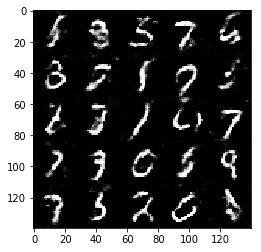

Epoch 2/2... Batch 283/938... Discriminator Loss: 1.3398... Generator Loss: 1.4063
This 20 batches takes:35.1770 sec
Epoch 2/2... Batch 303/938... Discriminator Loss: 1.3237... Generator Loss: 0.8470
This 20 batches takes:34.2124 sec
Epoch 2/2... Batch 323/938... Discriminator Loss: 1.3880... Generator Loss: 0.5119
This 20 batches takes:34.2244 sec
Epoch 2/2... Batch 343/938... Discriminator Loss: 1.5973... Generator Loss: 0.5537
This 20 batches takes:34.2094 sec
Epoch 2/2... Batch 363/938... Discriminator Loss: 1.3342... Generator Loss: 0.7881
This 20 batches takes:34.1943 sec
Epoch 2/2... Batch 383/938... Discriminator Loss: 1.6483... Generator Loss: 1.1221
This 20 batches takes:34.2674 sec
Epoch 2/2... Batch 403/938... Discriminator Loss: 1.5741... Generator Loss: 0.6764
This 20 batches takes:34.2324 sec
Epoch 2/2... Batch 423/938... Discriminator Loss: 1.4617... Generator Loss: 0.7476
This 20 batches takes:34.2424 sec
Epoch 2/2... Batch 443/938... Discriminator Loss: 1.3407... Gene

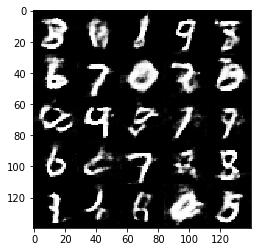

Epoch 2/2... Batch 483/938... Discriminator Loss: 1.4717... Generator Loss: 0.6524
This 20 batches takes:35.1450 sec
Epoch 2/2... Batch 503/938... Discriminator Loss: 1.2515... Generator Loss: 0.5201
This 20 batches takes:34.2104 sec
Epoch 2/2... Batch 523/938... Discriminator Loss: 1.3559... Generator Loss: 0.7811
This 20 batches takes:34.2244 sec
Epoch 2/2... Batch 543/938... Discriminator Loss: 1.4374... Generator Loss: 0.9561
This 20 batches takes:34.1933 sec
Epoch 2/2... Batch 563/938... Discriminator Loss: 1.2194... Generator Loss: 0.7888
This 20 batches takes:34.1953 sec
Epoch 2/2... Batch 583/938... Discriminator Loss: 1.3528... Generator Loss: 0.7086
This 20 batches takes:34.2314 sec
Epoch 2/2... Batch 603/938... Discriminator Loss: 1.4017... Generator Loss: 0.5814
This 20 batches takes:34.2503 sec
Epoch 2/2... Batch 623/938... Discriminator Loss: 1.4102... Generator Loss: 0.4509
This 20 batches takes:34.2474 sec
Epoch 2/2... Batch 643/938... Discriminator Loss: 1.3257... Gene

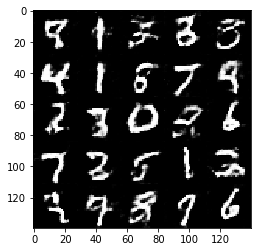

Epoch 2/2... Batch 683/938... Discriminator Loss: 1.7593... Generator Loss: 0.5256
This 20 batches takes:35.1550 sec
Epoch 2/2... Batch 703/938... Discriminator Loss: 1.2603... Generator Loss: 0.7923
This 20 batches takes:34.6796 sec
Epoch 2/2... Batch 723/938... Discriminator Loss: 1.1917... Generator Loss: 0.6304
This 20 batches takes:34.2594 sec
Epoch 2/2... Batch 743/938... Discriminator Loss: 1.4228... Generator Loss: 1.0885
This 20 batches takes:34.2454 sec
Epoch 2/2... Batch 763/938... Discriminator Loss: 1.2031... Generator Loss: 0.5049
This 20 batches takes:34.2916 sec
Epoch 2/2... Batch 783/938... Discriminator Loss: 1.4106... Generator Loss: 0.6550
This 20 batches takes:34.3034 sec
Epoch 2/2... Batch 803/938... Discriminator Loss: 1.4458... Generator Loss: 0.8208
This 20 batches takes:34.2404 sec
Epoch 2/2... Batch 823/938... Discriminator Loss: 1.1668... Generator Loss: 0.7546
This 20 batches takes:34.2834 sec
Epoch 2/2... Batch 843/938... Discriminator Loss: 1.4778... Gene

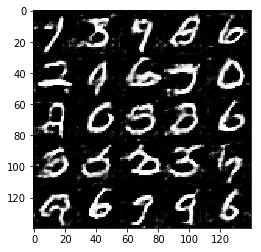

Epoch 2/2... Batch 883/938... Discriminator Loss: 1.3899... Generator Loss: 1.0563
This 20 batches takes:35.2731 sec
Epoch 2/2... Batch 903/938... Discriminator Loss: 1.4806... Generator Loss: 1.0103
This 20 batches takes:34.3535 sec
Epoch 2/2... Batch 923/938... Discriminator Loss: 1.1771... Generator Loss: 0.7695
This 20 batches takes:34.3004 sec


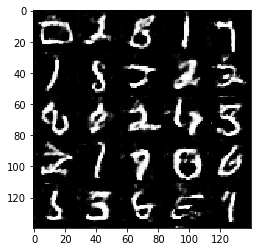

In [64]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 20/6332... Discriminator Loss: 1.2766... Generator Loss: 0.6728
This 20 batches takes:23.1004 sec
Epoch 1/1... Batch 40/6332... Discriminator Loss: 3.0552... Generator Loss: 0.1599
This 20 batches takes:22.2008 sec
Epoch 1/1... Batch 60/6332... Discriminator Loss: 1.9364... Generator Loss: 2.7025
This 20 batches takes:22.1088 sec
Epoch 1/1... Batch 80/6332... Discriminator Loss: 0.5489... Generator Loss: 2.4861
This 20 batches takes:22.3050 sec
Epoch 1/1... Batch 100/6332... Discriminator Loss: 1.0062... Generator Loss: 1.1717
This 20 batches takes:22.0580 sec
Epoch 1/1... Batch 120/6332... Discriminator Loss: 1.5649... Generator Loss: 0.9350
This 20 batches takes:22.0833 sec
Epoch 1/1... Batch 140/6332... Discriminator Loss: 1.3106... Generator Loss: 0.8829
This 20 batches takes:21.9026 sec
Epoch 1/1... Batch 160/6332... Discriminator Loss: 1.0356... Generator Loss: 1.3473
This 20 batches takes:21.7575 sec
Epoch 1/1... Batch 180/6332... Discriminator Loss: 0.6450...

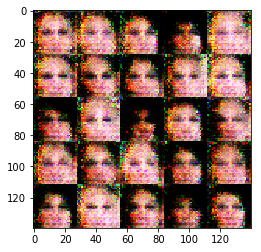

Epoch 1/1... Batch 220/6332... Discriminator Loss: 1.6489... Generator Loss: 0.4317
This 20 batches takes:27.4515 sec
Epoch 1/1... Batch 240/6332... Discriminator Loss: 2.0161... Generator Loss: 3.8656
This 20 batches takes:26.5284 sec
Epoch 1/1... Batch 260/6332... Discriminator Loss: 1.4441... Generator Loss: 0.5152
This 20 batches takes:25.9836 sec
Epoch 1/1... Batch 280/6332... Discriminator Loss: 0.8093... Generator Loss: 3.7600
This 20 batches takes:26.0756 sec
Epoch 1/1... Batch 300/6332... Discriminator Loss: 1.0962... Generator Loss: 0.4290
This 20 batches takes:25.7919 sec
Epoch 1/1... Batch 320/6332... Discriminator Loss: 1.2205... Generator Loss: 0.8309
This 20 batches takes:26.6289 sec
Epoch 1/1... Batch 340/6332... Discriminator Loss: 1.5364... Generator Loss: 0.4332
This 20 batches takes:26.1239 sec
Epoch 1/1... Batch 360/6332... Discriminator Loss: 0.9656... Generator Loss: 2.1350
This 20 batches takes:26.2306 sec
Epoch 1/1... Batch 380/6332... Discriminator Loss: 1.539

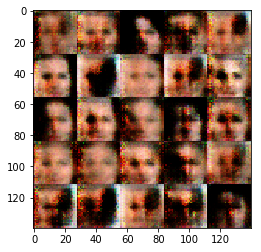

Epoch 1/1... Batch 420/6332... Discriminator Loss: 0.9540... Generator Loss: 1.2528
This 20 batches takes:27.6212 sec
Epoch 1/1... Batch 440/6332... Discriminator Loss: 0.8539... Generator Loss: 1.3731
This 20 batches takes:27.6392 sec
Epoch 1/1... Batch 460/6332... Discriminator Loss: 1.7538... Generator Loss: 0.5000
This 20 batches takes:27.3024 sec
Epoch 1/1... Batch 480/6332... Discriminator Loss: 1.0559... Generator Loss: 1.2110
This 20 batches takes:27.0596 sec
Epoch 1/1... Batch 500/6332... Discriminator Loss: 1.2607... Generator Loss: 0.9274
This 20 batches takes:25.7321 sec
Epoch 1/1... Batch 520/6332... Discriminator Loss: 1.1053... Generator Loss: 2.7438
This 20 batches takes:21.9417 sec
Epoch 1/1... Batch 540/6332... Discriminator Loss: 1.3252... Generator Loss: 0.7656
This 20 batches takes:21.9705 sec
Epoch 1/1... Batch 560/6332... Discriminator Loss: 1.5282... Generator Loss: 0.3530
This 20 batches takes:22.0081 sec
Epoch 1/1... Batch 580/6332... Discriminator Loss: 1.087

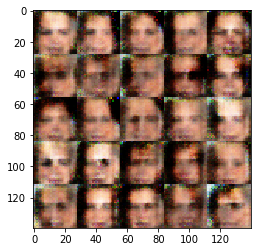

Epoch 1/1... Batch 620/6332... Discriminator Loss: 0.8567... Generator Loss: 1.2996
This 20 batches takes:23.2761 sec
Epoch 1/1... Batch 640/6332... Discriminator Loss: 1.3804... Generator Loss: 0.7619
This 20 batches takes:22.0340 sec
Epoch 1/1... Batch 660/6332... Discriminator Loss: 1.3133... Generator Loss: 1.2773
This 20 batches takes:21.8379 sec
Epoch 1/1... Batch 680/6332... Discriminator Loss: 1.2112... Generator Loss: 0.7228
This 20 batches takes:21.7555 sec
Epoch 1/1... Batch 700/6332... Discriminator Loss: 1.5820... Generator Loss: 0.4304
This 20 batches takes:21.8751 sec
Epoch 1/1... Batch 720/6332... Discriminator Loss: 1.5231... Generator Loss: 0.6994
This 20 batches takes:21.7635 sec
Epoch 1/1... Batch 740/6332... Discriminator Loss: 1.1397... Generator Loss: 0.7979
This 20 batches takes:21.7505 sec
Epoch 1/1... Batch 760/6332... Discriminator Loss: 1.0532... Generator Loss: 0.9812
This 20 batches takes:21.6854 sec
Epoch 1/1... Batch 780/6332... Discriminator Loss: 1.139

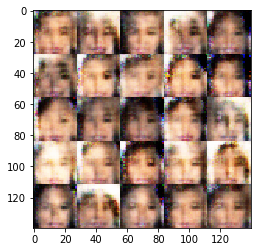

Epoch 1/1... Batch 820/6332... Discriminator Loss: 1.7312... Generator Loss: 0.2396
This 20 batches takes:22.7982 sec
Epoch 1/1... Batch 840/6332... Discriminator Loss: 1.2896... Generator Loss: 0.9434
This 20 batches takes:21.6926 sec
Epoch 1/1... Batch 860/6332... Discriminator Loss: 1.6908... Generator Loss: 0.9128
This 20 batches takes:21.9056 sec
Epoch 1/1... Batch 880/6332... Discriminator Loss: 1.4121... Generator Loss: 0.6975
This 20 batches takes:21.7935 sec
Epoch 1/1... Batch 900/6332... Discriminator Loss: 1.4606... Generator Loss: 0.8859
This 20 batches takes:21.7784 sec
Epoch 1/1... Batch 920/6332... Discriminator Loss: 1.5961... Generator Loss: 0.8539
This 20 batches takes:22.2005 sec
Epoch 1/1... Batch 940/6332... Discriminator Loss: 1.5301... Generator Loss: 0.4666
This 20 batches takes:22.2558 sec
Epoch 1/1... Batch 960/6332... Discriminator Loss: 1.4580... Generator Loss: 0.5925
This 20 batches takes:21.7485 sec
Epoch 1/1... Batch 980/6332... Discriminator Loss: 1.656

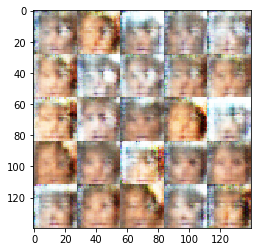

Epoch 1/1... Batch 1020/6332... Discriminator Loss: 1.2373... Generator Loss: 0.9615
This 20 batches takes:22.7772 sec
Epoch 1/1... Batch 1040/6332... Discriminator Loss: 1.3837... Generator Loss: 0.5757
This 20 batches takes:21.8336 sec
Epoch 1/1... Batch 1060/6332... Discriminator Loss: 1.4632... Generator Loss: 0.5511
This 20 batches takes:21.7685 sec
Epoch 1/1... Batch 1080/6332... Discriminator Loss: 1.2966... Generator Loss: 0.7933
This 20 batches takes:21.7035 sec
Epoch 1/1... Batch 1100/6332... Discriminator Loss: 1.5598... Generator Loss: 0.5748
This 20 batches takes:21.7880 sec
Epoch 1/1... Batch 1120/6332... Discriminator Loss: 1.3956... Generator Loss: 0.8356
This 20 batches takes:21.6917 sec
Epoch 1/1... Batch 1140/6332... Discriminator Loss: 1.5197... Generator Loss: 0.6511
This 20 batches takes:21.8315 sec
Epoch 1/1... Batch 1160/6332... Discriminator Loss: 1.3233... Generator Loss: 0.8307
This 20 batches takes:21.9186 sec
Epoch 1/1... Batch 1180/6332... Discriminator Lo

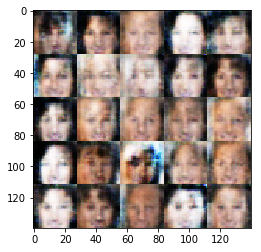

Epoch 1/1... Batch 1220/6332... Discriminator Loss: 1.3952... Generator Loss: 0.8995
This 20 batches takes:23.3597 sec
Epoch 1/1... Batch 1240/6332... Discriminator Loss: 1.2300... Generator Loss: 0.8086
This 20 batches takes:21.6664 sec
Epoch 1/1... Batch 1260/6332... Discriminator Loss: 1.3568... Generator Loss: 0.8733
This 20 batches takes:21.7147 sec
Epoch 1/1... Batch 1280/6332... Discriminator Loss: 1.7800... Generator Loss: 0.4286
This 20 batches takes:21.9591 sec
Epoch 1/1... Batch 1300/6332... Discriminator Loss: 1.3251... Generator Loss: 0.9557
This 20 batches takes:21.7999 sec
Epoch 1/1... Batch 1320/6332... Discriminator Loss: 1.4917... Generator Loss: 0.6894
This 20 batches takes:21.7925 sec
Epoch 1/1... Batch 1340/6332... Discriminator Loss: 1.6025... Generator Loss: 0.7490
This 20 batches takes:21.8516 sec
Epoch 1/1... Batch 1360/6332... Discriminator Loss: 1.7594... Generator Loss: 1.0450
This 20 batches takes:21.9677 sec
Epoch 1/1... Batch 1380/6332... Discriminator Lo

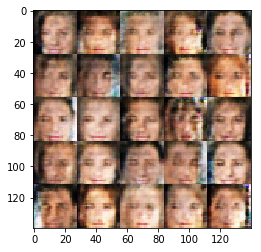

Epoch 1/1... Batch 1420/6332... Discriminator Loss: 1.2535... Generator Loss: 0.7966
This 20 batches takes:22.9268 sec
Epoch 1/1... Batch 1440/6332... Discriminator Loss: 1.6543... Generator Loss: 0.7074
This 20 batches takes:21.7804 sec
Epoch 1/1... Batch 1460/6332... Discriminator Loss: 1.6146... Generator Loss: 0.8158
This 20 batches takes:21.7538 sec
Epoch 1/1... Batch 1480/6332... Discriminator Loss: 1.3254... Generator Loss: 0.7524
This 20 batches takes:21.7812 sec
Epoch 1/1... Batch 1500/6332... Discriminator Loss: 1.4991... Generator Loss: 0.7132
This 20 batches takes:21.7055 sec
Epoch 1/1... Batch 1520/6332... Discriminator Loss: 1.5982... Generator Loss: 0.5855
This 20 batches takes:21.7475 sec
Epoch 1/1... Batch 1540/6332... Discriminator Loss: 1.5623... Generator Loss: 0.8239
This 20 batches takes:21.7565 sec
Epoch 1/1... Batch 1560/6332... Discriminator Loss: 1.3575... Generator Loss: 0.9378
This 20 batches takes:21.8365 sec
Epoch 1/1... Batch 1580/6332... Discriminator Lo

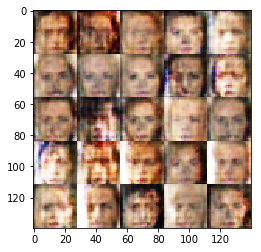

Epoch 1/1... Batch 1620/6332... Discriminator Loss: 1.2237... Generator Loss: 0.7886
This 20 batches takes:23.2545 sec
Epoch 1/1... Batch 1640/6332... Discriminator Loss: 1.4469... Generator Loss: 0.6181
This 20 batches takes:21.9576 sec
Epoch 1/1... Batch 1660/6332... Discriminator Loss: 1.4986... Generator Loss: 0.9481
This 20 batches takes:21.8996 sec
Epoch 1/1... Batch 1680/6332... Discriminator Loss: 1.5953... Generator Loss: 0.7520
This 20 batches takes:21.8856 sec
Epoch 1/1... Batch 1700/6332... Discriminator Loss: 1.4663... Generator Loss: 0.6011
This 20 batches takes:21.7415 sec
Epoch 1/1... Batch 1720/6332... Discriminator Loss: 1.4077... Generator Loss: 0.7326
This 20 batches takes:21.6624 sec
Epoch 1/1... Batch 1740/6332... Discriminator Loss: 1.5138... Generator Loss: 0.7076
This 20 batches takes:21.7315 sec
Epoch 1/1... Batch 1760/6332... Discriminator Loss: 1.4904... Generator Loss: 0.9964
This 20 batches takes:21.6893 sec
Epoch 1/1... Batch 1780/6332... Discriminator Lo

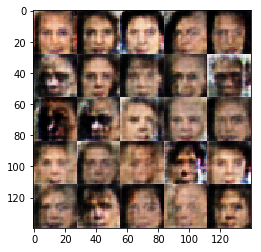

Epoch 1/1... Batch 1820/6332... Discriminator Loss: 1.3560... Generator Loss: 0.9013
This 20 batches takes:23.0171 sec
Epoch 1/1... Batch 1840/6332... Discriminator Loss: 1.6175... Generator Loss: 0.6214
This 20 batches takes:21.7973 sec
Epoch 1/1... Batch 1860/6332... Discriminator Loss: 1.3746... Generator Loss: 0.7948
This 20 batches takes:21.7705 sec
Epoch 1/1... Batch 1880/6332... Discriminator Loss: 1.4147... Generator Loss: 0.6998
This 20 batches takes:21.7680 sec
Epoch 1/1... Batch 1900/6332... Discriminator Loss: 1.6975... Generator Loss: 0.5650
This 20 batches takes:21.7585 sec
Epoch 1/1... Batch 1920/6332... Discriminator Loss: 1.4686... Generator Loss: 0.6537
This 20 batches takes:21.7745 sec
Epoch 1/1... Batch 1940/6332... Discriminator Loss: 1.5257... Generator Loss: 0.7768
This 20 batches takes:21.7728 sec
Epoch 1/1... Batch 1960/6332... Discriminator Loss: 1.6271... Generator Loss: 0.6614
This 20 batches takes:21.8591 sec
Epoch 1/1... Batch 1980/6332... Discriminator Lo

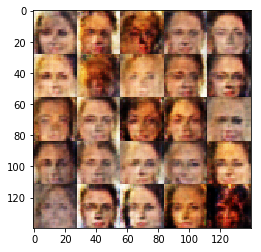

Epoch 1/1... Batch 2020/6332... Discriminator Loss: 1.4047... Generator Loss: 0.7966
This 20 batches takes:23.2514 sec
Epoch 1/1... Batch 2040/6332... Discriminator Loss: 1.3672... Generator Loss: 0.8659
This 20 batches takes:21.9807 sec
Epoch 1/1... Batch 2060/6332... Discriminator Loss: 1.3968... Generator Loss: 0.7680
This 20 batches takes:21.7721 sec
Epoch 1/1... Batch 2080/6332... Discriminator Loss: 1.5056... Generator Loss: 0.6625
This 20 batches takes:21.7231 sec
Epoch 1/1... Batch 2100/6332... Discriminator Loss: 1.6452... Generator Loss: 0.5901
This 20 batches takes:21.7488 sec
Epoch 1/1... Batch 2120/6332... Discriminator Loss: 1.2161... Generator Loss: 0.7812
This 20 batches takes:21.7185 sec
Epoch 1/1... Batch 2140/6332... Discriminator Loss: 1.5962... Generator Loss: 0.6593
This 20 batches takes:21.7788 sec
Epoch 1/1... Batch 2160/6332... Discriminator Loss: 1.5725... Generator Loss: 0.5864
This 20 batches takes:21.7435 sec
Epoch 1/1... Batch 2180/6332... Discriminator Lo

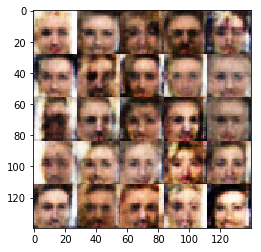

Epoch 1/1... Batch 2220/6332... Discriminator Loss: 1.4538... Generator Loss: 0.7514
This 20 batches takes:23.8810 sec
Epoch 1/1... Batch 2240/6332... Discriminator Loss: 1.5874... Generator Loss: 0.6464
This 20 batches takes:21.7666 sec
Epoch 1/1... Batch 2260/6332... Discriminator Loss: 1.4645... Generator Loss: 0.6198
This 20 batches takes:21.9421 sec
Epoch 1/1... Batch 2280/6332... Discriminator Loss: 1.5582... Generator Loss: 0.6488
This 20 batches takes:21.9928 sec
Epoch 1/1... Batch 2300/6332... Discriminator Loss: 1.5464... Generator Loss: 0.6554
This 20 batches takes:21.7665 sec
Epoch 1/1... Batch 2320/6332... Discriminator Loss: 1.4751... Generator Loss: 0.7100
This 20 batches takes:21.7908 sec
Epoch 1/1... Batch 2340/6332... Discriminator Loss: 1.4729... Generator Loss: 0.8914
This 20 batches takes:22.0132 sec
Epoch 1/1... Batch 2360/6332... Discriminator Loss: 1.6065... Generator Loss: 0.4891
This 20 batches takes:21.7325 sec
Epoch 1/1... Batch 2380/6332... Discriminator Lo

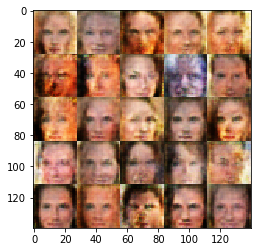

Epoch 1/1... Batch 2420/6332... Discriminator Loss: 1.4270... Generator Loss: 0.8008
This 20 batches takes:22.6962 sec
Epoch 1/1... Batch 2440/6332... Discriminator Loss: 1.3219... Generator Loss: 0.5952
This 20 batches takes:21.7004 sec
Epoch 1/1... Batch 2460/6332... Discriminator Loss: 1.2764... Generator Loss: 0.5269
This 20 batches takes:21.7455 sec
Epoch 1/1... Batch 2480/6332... Discriminator Loss: 1.6588... Generator Loss: 0.6120
This 20 batches takes:21.6324 sec
Epoch 1/1... Batch 2500/6332... Discriminator Loss: 1.5681... Generator Loss: 0.4749
This 20 batches takes:21.6954 sec
Epoch 1/1... Batch 2520/6332... Discriminator Loss: 1.5246... Generator Loss: 0.7493
This 20 batches takes:21.7235 sec
Epoch 1/1... Batch 2540/6332... Discriminator Loss: 1.7446... Generator Loss: 0.5876
This 20 batches takes:21.6684 sec
Epoch 1/1... Batch 2560/6332... Discriminator Loss: 1.3815... Generator Loss: 0.6489
This 20 batches takes:21.6774 sec
Epoch 1/1... Batch 2580/6332... Discriminator Lo

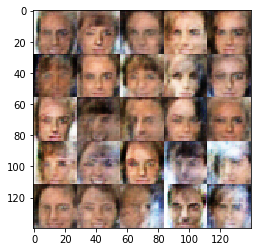

Epoch 1/1... Batch 2620/6332... Discriminator Loss: 1.3938... Generator Loss: 0.7482
This 20 batches takes:22.6751 sec
Epoch 1/1... Batch 2640/6332... Discriminator Loss: 1.4631... Generator Loss: 0.7762
This 20 batches takes:21.7235 sec
Epoch 1/1... Batch 2660/6332... Discriminator Loss: 1.4185... Generator Loss: 0.6861
This 20 batches takes:21.7035 sec
Epoch 1/1... Batch 2680/6332... Discriminator Loss: 1.2562... Generator Loss: 0.9609
This 20 batches takes:21.6404 sec
Epoch 1/1... Batch 2700/6332... Discriminator Loss: 1.6289... Generator Loss: 0.7844
This 20 batches takes:21.7135 sec
Epoch 1/1... Batch 2720/6332... Discriminator Loss: 1.8056... Generator Loss: 0.5614
This 20 batches takes:21.6274 sec
Epoch 1/1... Batch 2740/6332... Discriminator Loss: 1.3420... Generator Loss: 0.7547
This 20 batches takes:21.6994 sec
Epoch 1/1... Batch 2760/6332... Discriminator Loss: 1.5525... Generator Loss: 0.6628
This 20 batches takes:21.7085 sec
Epoch 1/1... Batch 2780/6332... Discriminator Lo

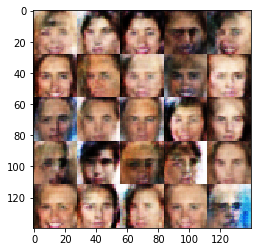

Epoch 1/1... Batch 2820/6332... Discriminator Loss: 1.4363... Generator Loss: 0.8067
This 20 batches takes:22.7312 sec
Epoch 1/1... Batch 2840/6332... Discriminator Loss: 1.3695... Generator Loss: 0.6868
This 20 batches takes:21.6524 sec
Epoch 1/1... Batch 2860/6332... Discriminator Loss: 1.6241... Generator Loss: 0.6240
This 20 batches takes:21.6784 sec
Epoch 1/1... Batch 2880/6332... Discriminator Loss: 1.7131... Generator Loss: 0.6464
This 20 batches takes:21.7125 sec
Epoch 1/1... Batch 2900/6332... Discriminator Loss: 1.3962... Generator Loss: 0.7450
This 20 batches takes:21.6694 sec
Epoch 1/1... Batch 2920/6332... Discriminator Loss: 1.5096... Generator Loss: 0.5808
This 20 batches takes:21.6714 sec
Epoch 1/1... Batch 2940/6332... Discriminator Loss: 1.5823... Generator Loss: 0.7200
This 20 batches takes:21.7095 sec
Epoch 1/1... Batch 2960/6332... Discriminator Loss: 1.5733... Generator Loss: 0.7094
This 20 batches takes:21.6314 sec
Epoch 1/1... Batch 2980/6332... Discriminator Lo

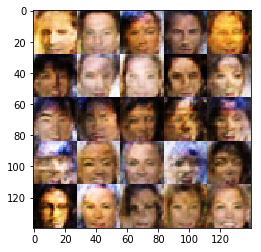

Epoch 1/1... Batch 3020/6332... Discriminator Loss: 1.3053... Generator Loss: 0.8160
This 20 batches takes:22.7292 sec
Epoch 1/1... Batch 3040/6332... Discriminator Loss: 1.4943... Generator Loss: 0.7118
This 20 batches takes:21.6934 sec
Epoch 1/1... Batch 3060/6332... Discriminator Loss: 1.3870... Generator Loss: 0.7632
This 20 batches takes:21.7185 sec
Epoch 1/1... Batch 3080/6332... Discriminator Loss: 1.5982... Generator Loss: 0.5715
This 20 batches takes:21.6564 sec
Epoch 1/1... Batch 3100/6332... Discriminator Loss: 1.4418... Generator Loss: 0.7982
This 20 batches takes:21.7255 sec
Epoch 1/1... Batch 3120/6332... Discriminator Loss: 1.5729... Generator Loss: 0.6604
This 20 batches takes:21.7035 sec
Epoch 1/1... Batch 3140/6332... Discriminator Loss: 1.4573... Generator Loss: 0.8231
This 20 batches takes:21.6784 sec
Epoch 1/1... Batch 3160/6332... Discriminator Loss: 1.3753... Generator Loss: 0.7569
This 20 batches takes:21.6494 sec
Epoch 1/1... Batch 3180/6332... Discriminator Lo

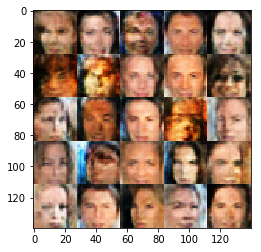

Epoch 1/1... Batch 3220/6332... Discriminator Loss: 1.6489... Generator Loss: 0.5608
This 20 batches takes:22.6711 sec
Epoch 1/1... Batch 3240/6332... Discriminator Loss: 1.3948... Generator Loss: 0.7980
This 20 batches takes:21.6594 sec
Epoch 1/1... Batch 3260/6332... Discriminator Loss: 1.4567... Generator Loss: 0.8198
This 20 batches takes:21.7045 sec
Epoch 1/1... Batch 3280/6332... Discriminator Loss: 1.4488... Generator Loss: 0.7637
This 20 batches takes:21.6854 sec
Epoch 1/1... Batch 3300/6332... Discriminator Loss: 1.3873... Generator Loss: 0.8313
This 20 batches takes:21.7305 sec
Epoch 1/1... Batch 3320/6332... Discriminator Loss: 1.3796... Generator Loss: 0.7261
This 20 batches takes:21.6444 sec
Epoch 1/1... Batch 3340/6332... Discriminator Loss: 1.4741... Generator Loss: 0.6125
This 20 batches takes:21.6894 sec
Epoch 1/1... Batch 3360/6332... Discriminator Loss: 1.4372... Generator Loss: 0.7713
This 20 batches takes:21.6724 sec
Epoch 1/1... Batch 3380/6332... Discriminator Lo

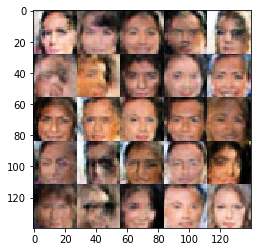

Epoch 1/1... Batch 3420/6332... Discriminator Loss: 1.3689... Generator Loss: 0.8808
This 20 batches takes:22.8543 sec
Epoch 1/1... Batch 3440/6332... Discriminator Loss: 1.5468... Generator Loss: 0.7703
This 20 batches takes:21.6574 sec
Epoch 1/1... Batch 3460/6332... Discriminator Loss: 1.3345... Generator Loss: 0.7213
This 20 batches takes:21.6684 sec
Epoch 1/1... Batch 3480/6332... Discriminator Loss: 1.4675... Generator Loss: 0.6795
This 20 batches takes:22.8107 sec
Epoch 1/1... Batch 3500/6332... Discriminator Loss: 1.5642... Generator Loss: 0.6302
This 20 batches takes:21.8846 sec
Epoch 1/1... Batch 3520/6332... Discriminator Loss: 1.4553... Generator Loss: 0.6339
This 20 batches takes:21.7605 sec
Epoch 1/1... Batch 3540/6332... Discriminator Loss: 1.4448... Generator Loss: 0.6032
This 20 batches takes:21.8773 sec
Epoch 1/1... Batch 3560/6332... Discriminator Loss: 1.6305... Generator Loss: 0.7482
This 20 batches takes:21.9190 sec
Epoch 1/1... Batch 3580/6332... Discriminator Lo

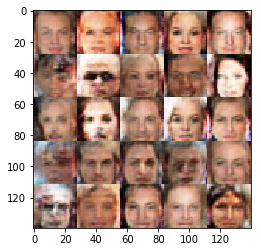

Epoch 1/1... Batch 3620/6332... Discriminator Loss: 1.4224... Generator Loss: 0.7040
This 20 batches takes:23.0023 sec
Epoch 1/1... Batch 3640/6332... Discriminator Loss: 1.4940... Generator Loss: 0.9880
This 20 batches takes:21.9154 sec
Epoch 1/1... Batch 3660/6332... Discriminator Loss: 1.4645... Generator Loss: 0.6127
This 20 batches takes:21.9399 sec
Epoch 1/1... Batch 3680/6332... Discriminator Loss: 1.6429... Generator Loss: 0.6533
This 20 batches takes:21.7870 sec
Epoch 1/1... Batch 3700/6332... Discriminator Loss: 1.4574... Generator Loss: 0.7288
This 20 batches takes:21.8170 sec
Epoch 1/1... Batch 3720/6332... Discriminator Loss: 1.3838... Generator Loss: 0.8073
This 20 batches takes:21.9321 sec
Epoch 1/1... Batch 3740/6332... Discriminator Loss: 1.5248... Generator Loss: 0.6643
This 20 batches takes:21.7796 sec
Epoch 1/1... Batch 3760/6332... Discriminator Loss: 1.5351... Generator Loss: 0.6519
This 20 batches takes:21.8037 sec
Epoch 1/1... Batch 3780/6332... Discriminator Lo

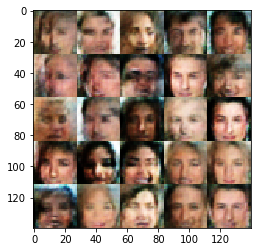

Epoch 1/1... Batch 3820/6332... Discriminator Loss: 1.4588... Generator Loss: 0.6159
This 20 batches takes:22.9023 sec
Epoch 1/1... Batch 3840/6332... Discriminator Loss: 1.5711... Generator Loss: 0.7518
This 20 batches takes:21.8460 sec
Epoch 1/1... Batch 3860/6332... Discriminator Loss: 1.6177... Generator Loss: 0.7328
This 20 batches takes:22.1903 sec
Epoch 1/1... Batch 3880/6332... Discriminator Loss: 1.4732... Generator Loss: 0.7389
This 20 batches takes:22.0557 sec
Epoch 1/1... Batch 3900/6332... Discriminator Loss: 1.6669... Generator Loss: 0.7188
This 20 batches takes:21.7715 sec
Epoch 1/1... Batch 3920/6332... Discriminator Loss: 1.3590... Generator Loss: 0.8498
This 20 batches takes:21.6604 sec
Epoch 1/1... Batch 3940/6332... Discriminator Loss: 1.3706... Generator Loss: 0.7789
This 20 batches takes:21.6694 sec
Epoch 1/1... Batch 3960/6332... Discriminator Loss: 1.4062... Generator Loss: 0.7614
This 20 batches takes:21.7055 sec
Epoch 1/1... Batch 3980/6332... Discriminator Lo

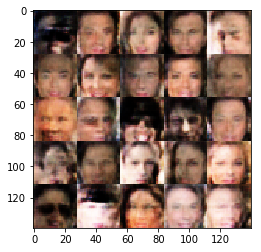

Epoch 1/1... Batch 4020/6332... Discriminator Loss: 1.4392... Generator Loss: 0.6552
This 20 batches takes:22.8483 sec
Epoch 1/1... Batch 4040/6332... Discriminator Loss: 1.4381... Generator Loss: 0.8153
This 20 batches takes:21.6914 sec
Epoch 1/1... Batch 4060/6332... Discriminator Loss: 1.4704... Generator Loss: 0.7786
This 20 batches takes:21.6905 sec
Epoch 1/1... Batch 4080/6332... Discriminator Loss: 1.3736... Generator Loss: 0.7091
This 20 batches takes:21.7605 sec
Epoch 1/1... Batch 4100/6332... Discriminator Loss: 1.5242... Generator Loss: 0.6989
This 20 batches takes:22.4598 sec
Epoch 1/1... Batch 4120/6332... Discriminator Loss: 1.4470... Generator Loss: 0.6448
This 20 batches takes:21.8568 sec
Epoch 1/1... Batch 4140/6332... Discriminator Loss: 1.5480... Generator Loss: 0.6962
This 20 batches takes:21.9862 sec
Epoch 1/1... Batch 4160/6332... Discriminator Loss: 1.4822... Generator Loss: 0.6459
This 20 batches takes:21.9043 sec
Epoch 1/1... Batch 4180/6332... Discriminator Lo

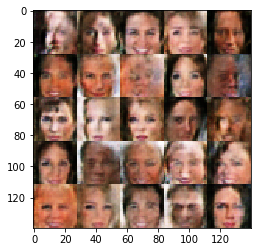

Epoch 1/1... Batch 4220/6332... Discriminator Loss: 1.4459... Generator Loss: 0.6161
This 20 batches takes:22.9568 sec
Epoch 1/1... Batch 4240/6332... Discriminator Loss: 1.3955... Generator Loss: 0.7583
This 20 batches takes:21.9136 sec
Epoch 1/1... Batch 4260/6332... Discriminator Loss: 1.4933... Generator Loss: 0.6939
This 20 batches takes:21.9523 sec
Epoch 1/1... Batch 4280/6332... Discriminator Loss: 1.4390... Generator Loss: 0.8280
This 20 batches takes:21.9293 sec
Epoch 1/1... Batch 4300/6332... Discriminator Loss: 1.5678... Generator Loss: 0.6054
This 20 batches takes:21.8065 sec
Epoch 1/1... Batch 4320/6332... Discriminator Loss: 1.4630... Generator Loss: 0.7040
This 20 batches takes:21.9051 sec
Epoch 1/1... Batch 4340/6332... Discriminator Loss: 1.3774... Generator Loss: 0.8339
This 20 batches takes:21.7921 sec
Epoch 1/1... Batch 4360/6332... Discriminator Loss: 1.3602... Generator Loss: 0.7127
This 20 batches takes:21.7620 sec
Epoch 1/1... Batch 4380/6332... Discriminator Lo

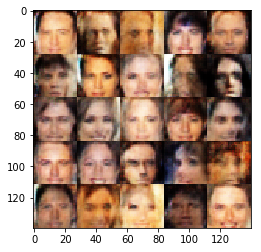

Epoch 1/1... Batch 4420/6332... Discriminator Loss: 1.5241... Generator Loss: 0.6577
This 20 batches takes:23.3164 sec
Epoch 1/1... Batch 4440/6332... Discriminator Loss: 1.3355... Generator Loss: 0.7665
This 20 batches takes:21.8597 sec
Epoch 1/1... Batch 4460/6332... Discriminator Loss: 1.4543... Generator Loss: 0.8114
This 20 batches takes:21.8292 sec
Epoch 1/1... Batch 4480/6332... Discriminator Loss: 1.5292... Generator Loss: 0.6925
This 20 batches takes:21.8096 sec
Epoch 1/1... Batch 4500/6332... Discriminator Loss: 1.6436... Generator Loss: 0.6365
This 20 batches takes:21.8876 sec
Epoch 1/1... Batch 4520/6332... Discriminator Loss: 1.4472... Generator Loss: 0.7819
This 20 batches takes:21.8576 sec
Epoch 1/1... Batch 4540/6332... Discriminator Loss: 1.4645... Generator Loss: 0.6832
This 20 batches takes:21.8654 sec
Epoch 1/1... Batch 4560/6332... Discriminator Loss: 1.3571... Generator Loss: 0.7726
This 20 batches takes:21.9507 sec
Epoch 1/1... Batch 4580/6332... Discriminator Lo

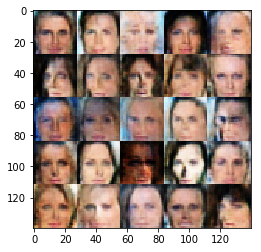

Epoch 1/1... Batch 4620/6332... Discriminator Loss: 1.4079... Generator Loss: 0.6138
This 20 batches takes:24.0517 sec
Epoch 1/1... Batch 4640/6332... Discriminator Loss: 1.3071... Generator Loss: 0.6420
This 20 batches takes:21.8379 sec
Epoch 1/1... Batch 4660/6332... Discriminator Loss: 1.3663... Generator Loss: 0.6280
This 20 batches takes:21.8068 sec
Epoch 1/1... Batch 4680/6332... Discriminator Loss: 1.3592... Generator Loss: 0.8255
This 20 batches takes:21.8388 sec
Epoch 1/1... Batch 4700/6332... Discriminator Loss: 1.3497... Generator Loss: 0.8168
This 20 batches takes:21.8333 sec
Epoch 1/1... Batch 4720/6332... Discriminator Loss: 1.3996... Generator Loss: 0.7340
This 20 batches takes:21.9148 sec
Epoch 1/1... Batch 4740/6332... Discriminator Loss: 1.3943... Generator Loss: 0.7667
This 20 batches takes:21.8025 sec
Epoch 1/1... Batch 4760/6332... Discriminator Loss: 1.5027... Generator Loss: 0.7291
This 20 batches takes:21.7207 sec
Epoch 1/1... Batch 4780/6332... Discriminator Lo

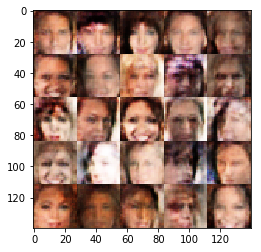

Epoch 1/1... Batch 4820/6332... Discriminator Loss: 1.3751... Generator Loss: 0.7117
This 20 batches takes:22.9721 sec
Epoch 1/1... Batch 4840/6332... Discriminator Loss: 1.5252... Generator Loss: 0.6257
This 20 batches takes:21.7865 sec
Epoch 1/1... Batch 4860/6332... Discriminator Loss: 1.2592... Generator Loss: 0.7260
This 20 batches takes:21.7885 sec
Epoch 1/1... Batch 4880/6332... Discriminator Loss: 1.3167... Generator Loss: 0.7455
This 20 batches takes:21.7275 sec
Epoch 1/1... Batch 4900/6332... Discriminator Loss: 1.4659... Generator Loss: 0.6070
This 20 batches takes:21.7155 sec
Epoch 1/1... Batch 4920/6332... Discriminator Loss: 1.5889... Generator Loss: 0.8282
This 20 batches takes:21.7525 sec
Epoch 1/1... Batch 4940/6332... Discriminator Loss: 1.3492... Generator Loss: 0.6786
This 20 batches takes:21.8124 sec
Epoch 1/1... Batch 4960/6332... Discriminator Loss: 1.4549... Generator Loss: 0.8461
This 20 batches takes:21.7960 sec
Epoch 1/1... Batch 4980/6332... Discriminator Lo

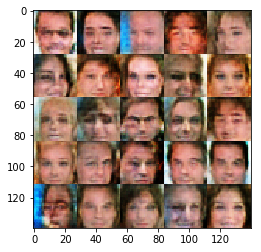

Epoch 1/1... Batch 5020/6332... Discriminator Loss: 1.2871... Generator Loss: 0.6478
This 20 batches takes:22.8403 sec
Epoch 1/1... Batch 5040/6332... Discriminator Loss: 1.3960... Generator Loss: 0.6171
This 20 batches takes:21.8973 sec
Epoch 1/1... Batch 5060/6332... Discriminator Loss: 1.4339... Generator Loss: 0.8965
This 20 batches takes:21.9476 sec
Epoch 1/1... Batch 5080/6332... Discriminator Loss: 1.2795... Generator Loss: 0.7092
This 20 batches takes:21.7842 sec
Epoch 1/1... Batch 5100/6332... Discriminator Loss: 1.3094... Generator Loss: 0.8812
This 20 batches takes:21.7905 sec
Epoch 1/1... Batch 5120/6332... Discriminator Loss: 1.4453... Generator Loss: 0.7267
This 20 batches takes:21.7135 sec
Epoch 1/1... Batch 5140/6332... Discriminator Loss: 1.3606... Generator Loss: 0.7784
This 20 batches takes:21.7634 sec
Epoch 1/1... Batch 5160/6332... Discriminator Loss: 1.4119... Generator Loss: 0.7695
This 20 batches takes:21.7215 sec
Epoch 1/1... Batch 5180/6332... Discriminator Lo

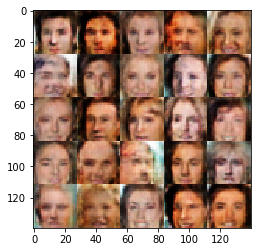

Epoch 1/1... Batch 5220/6332... Discriminator Loss: 1.4010... Generator Loss: 0.9502
This 20 batches takes:23.9160 sec
Epoch 1/1... Batch 5240/6332... Discriminator Loss: 1.3866... Generator Loss: 0.8509
This 20 batches takes:21.9086 sec
Epoch 1/1... Batch 5260/6332... Discriminator Loss: 1.5385... Generator Loss: 0.6701
This 20 batches takes:21.8355 sec
Epoch 1/1... Batch 5280/6332... Discriminator Loss: 1.4165... Generator Loss: 0.6908
This 20 batches takes:21.7705 sec
Epoch 1/1... Batch 5300/6332... Discriminator Loss: 1.4444... Generator Loss: 0.6417
This 20 batches takes:21.9036 sec
Epoch 1/1... Batch 5320/6332... Discriminator Loss: 1.4409... Generator Loss: 1.0319
This 20 batches takes:21.7393 sec
Epoch 1/1... Batch 5340/6332... Discriminator Loss: 1.4194... Generator Loss: 0.7097
This 20 batches takes:21.8426 sec
Epoch 1/1... Batch 5360/6332... Discriminator Loss: 1.3907... Generator Loss: 0.7204
This 20 batches takes:21.7991 sec
Epoch 1/1... Batch 5380/6332... Discriminator Lo

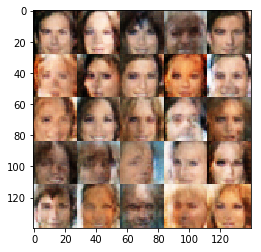

Epoch 1/1... Batch 5420/6332... Discriminator Loss: 1.4264... Generator Loss: 0.7078
This 20 batches takes:22.8112 sec
Epoch 1/1... Batch 5440/6332... Discriminator Loss: 1.4426... Generator Loss: 0.6336
This 20 batches takes:21.6904 sec
Epoch 1/1... Batch 5460/6332... Discriminator Loss: 1.3947... Generator Loss: 0.9739
This 20 batches takes:21.7835 sec
Epoch 1/1... Batch 5480/6332... Discriminator Loss: 1.3823... Generator Loss: 0.7992
This 20 batches takes:21.7315 sec
Epoch 1/1... Batch 5500/6332... Discriminator Loss: 1.4974... Generator Loss: 0.5875
This 20 batches takes:21.7335 sec
Epoch 1/1... Batch 5520/6332... Discriminator Loss: 1.4357... Generator Loss: 0.8414
This 20 batches takes:21.8095 sec
Epoch 1/1... Batch 5540/6332... Discriminator Loss: 1.3393... Generator Loss: 0.7875
This 20 batches takes:21.7315 sec
Epoch 1/1... Batch 5560/6332... Discriminator Loss: 1.5158... Generator Loss: 0.5831
This 20 batches takes:21.7345 sec
Epoch 1/1... Batch 5580/6332... Discriminator Lo

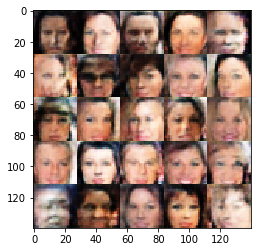

Epoch 1/1... Batch 5620/6332... Discriminator Loss: 1.7259... Generator Loss: 0.6510
This 20 batches takes:22.9802 sec
Epoch 1/1... Batch 5640/6332... Discriminator Loss: 1.4711... Generator Loss: 0.6032
This 20 batches takes:22.0357 sec
Epoch 1/1... Batch 5660/6332... Discriminator Loss: 1.3029... Generator Loss: 0.7618
This 20 batches takes:21.7375 sec
Epoch 1/1... Batch 5680/6332... Discriminator Loss: 1.4530... Generator Loss: 0.7092
This 20 batches takes:21.6754 sec
Epoch 1/1... Batch 5700/6332... Discriminator Loss: 1.3140... Generator Loss: 0.7604
This 20 batches takes:21.7715 sec
Epoch 1/1... Batch 5720/6332... Discriminator Loss: 1.6201... Generator Loss: 0.6480
This 20 batches takes:21.7035 sec
Epoch 1/1... Batch 5740/6332... Discriminator Loss: 1.3889... Generator Loss: 0.7361
This 20 batches takes:21.6694 sec
Epoch 1/1... Batch 5760/6332... Discriminator Loss: 1.3087... Generator Loss: 0.7390
This 20 batches takes:21.7205 sec
Epoch 1/1... Batch 5780/6332... Discriminator Lo

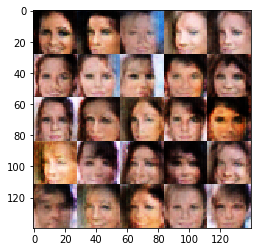

Epoch 1/1... Batch 5820/6332... Discriminator Loss: 1.4233... Generator Loss: 0.7844
This 20 batches takes:22.9083 sec
Epoch 1/1... Batch 5840/6332... Discriminator Loss: 1.3647... Generator Loss: 0.6921
This 20 batches takes:21.6684 sec
Epoch 1/1... Batch 5860/6332... Discriminator Loss: 1.3537... Generator Loss: 0.8991
This 20 batches takes:21.7255 sec
Epoch 1/1... Batch 5880/6332... Discriminator Loss: 1.4475... Generator Loss: 0.5755
This 20 batches takes:21.7065 sec
Epoch 1/1... Batch 5900/6332... Discriminator Loss: 1.5536... Generator Loss: 0.6838
This 20 batches takes:21.6784 sec
Epoch 1/1... Batch 5920/6332... Discriminator Loss: 1.3827... Generator Loss: 0.7616
This 20 batches takes:21.6884 sec
Epoch 1/1... Batch 5940/6332... Discriminator Loss: 1.4859... Generator Loss: 0.6383
This 20 batches takes:21.7375 sec
Epoch 1/1... Batch 5960/6332... Discriminator Loss: 1.5428... Generator Loss: 0.7442
This 20 batches takes:21.8912 sec
Epoch 1/1... Batch 5980/6332... Discriminator Lo

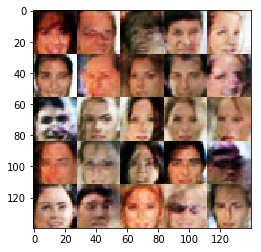

Epoch 1/1... Batch 6020/6332... Discriminator Loss: 1.3687... Generator Loss: 0.7637
This 20 batches takes:23.0110 sec
Epoch 1/1... Batch 6040/6332... Discriminator Loss: 1.6370... Generator Loss: 0.6081
This 20 batches takes:22.0072 sec
Epoch 1/1... Batch 6060/6332... Discriminator Loss: 1.4849... Generator Loss: 0.6675
This 20 batches takes:21.7385 sec
Epoch 1/1... Batch 6080/6332... Discriminator Loss: 1.4015... Generator Loss: 0.6480
This 20 batches takes:21.6804 sec
Epoch 1/1... Batch 6100/6332... Discriminator Loss: 1.4289... Generator Loss: 0.5715
This 20 batches takes:21.7004 sec
Epoch 1/1... Batch 6120/6332... Discriminator Loss: 1.3599... Generator Loss: 0.8739
This 20 batches takes:21.7605 sec
Epoch 1/1... Batch 6140/6332... Discriminator Loss: 1.5529... Generator Loss: 0.5540
This 20 batches takes:21.6884 sec
Epoch 1/1... Batch 6160/6332... Discriminator Loss: 1.3550... Generator Loss: 0.6687
This 20 batches takes:21.7215 sec
Epoch 1/1... Batch 6180/6332... Discriminator Lo

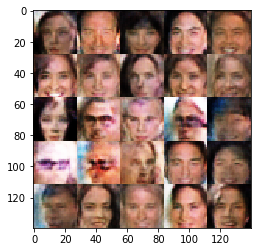

Epoch 1/1... Batch 6220/6332... Discriminator Loss: 1.4824... Generator Loss: 0.6053
This 20 batches takes:22.8759 sec
Epoch 1/1... Batch 6240/6332... Discriminator Loss: 1.3921... Generator Loss: 0.7669
This 20 batches takes:21.7175 sec
Epoch 1/1... Batch 6260/6332... Discriminator Loss: 1.5782... Generator Loss: 0.7261
This 20 batches takes:21.6854 sec
Epoch 1/1... Batch 6280/6332... Discriminator Loss: 1.4128... Generator Loss: 0.8452
This 20 batches takes:21.6574 sec
Epoch 1/1... Batch 6300/6332... Discriminator Loss: 1.3865... Generator Loss: 0.5524
This 20 batches takes:21.7045 sec
Epoch 1/1... Batch 6320/6332... Discriminator Loss: 1.5168... Generator Loss: 0.5789
This 20 batches takes:21.6615 sec


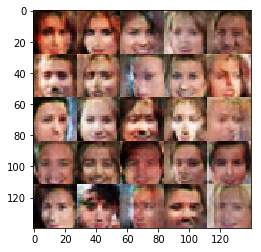

In [65]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.